# Gender Face Recognition DNN

## Importing dataset

In [1]:
import pandas

data = pandas.read_csv("./age_gender.csv")
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


### Example of Image

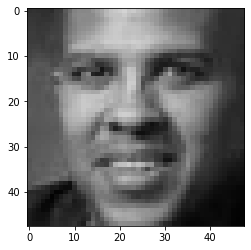

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import math

image = data['pixels'][15000].split(' ')
image = [int(x) for x in image]
image = np.array(image)

size = int(math.sqrt(len(data['pixels'][1].split(' '))))

image = np.resize(image, (size, size))

plt.imshow(image, cmap='gray', vmin=0, vmax=255)

### Classes distribution

<AxesSubplot:>

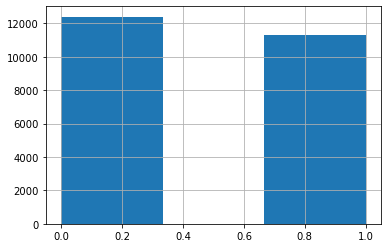

In [3]:
data['gender'].hist(bins=3)

## Dumping images

In [4]:
import os
from matplotlib import pyplot as plt
import numpy as np
import math
from PIL import Image
from tqdm import tqdm


def filter(dataDF):
    result = dataDF[dataDF['age'] > 20][dataDF['age'] < 60]
    result = result.reset_index()
    return result

def dumpImages(dataDF, path):
    os.system('rm -rf {}'.format(path))

    dataDF = dataDF.reset_index()

    numberOfImages = dataDF.shape[0]
    size = int(math.sqrt(len(dataDF['pixels'][0].split(' '))))
    os.mkdir(path)
    os.mkdir('{}/male'.format(path))
    os.mkdir('{}/female'.format(path))
    for i in tqdm(range(numberOfImages), desc='{} is dumping'.format(path)):
        image = dataDF['pixels'][i].split(' ')
        image = [int(x) for x in image]
        image = np.array(image).astype(np.uint8)

        image = np.resize(image, (size, size))

        image = Image.fromarray(image)
        if dataDF['gender'][i] == 0:
            image.save('{}/male/{}.jpeg'.format(path, i), 'JPEG')
        else:
            image.save('{}/female/{}.jpeg'.format(path, i), 'JPEG')


data = filter(data)
dumpImages(data, './images')

./images is dumping: 100%|██████████| 16140/16140 [00:10<00:00, 1478.79it/s]


## Spliting to train, test and val dataset

In [5]:
from sklearn.model_selection import train_test_split


def splitTrainTestVal(data, trainSize, testSize, randomState):
    if trainSize + testSize >= 1.0:
        return None
    valSize = 1.0 - trainSize - testSize

    dataTrainIndex, dataTestValIndex = train_test_split(data.index, train_size=trainSize, random_state=randomState)
    dataTestIndex, dataValIndex = train_test_split(dataTestValIndex, train_size=testSize / (testSize + valSize), random_state=randomState)

    return data.iloc[dataTrainIndex], data.iloc[dataTestIndex], data.iloc[dataValIndex]


train, test, val = splitTrainTestVal(data, 0.70, 0.2, 42)

dumpImages(train, './train')
dumpImages(test, './test')
dumpImages(val, './val')

./val is dumping: 100%|██████████| 1614/1614 [00:01<00:00, 1481.78it/s]


## Transforms and DataLoaders

Text(0.5, 1.0, 'Class of image 0')

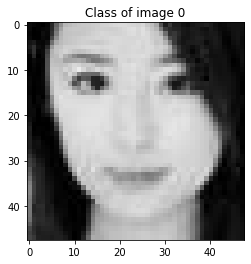

In [6]:
from torchvision import datasets, transforms
import torch
import numpy as np


def setTorchRandomState(randomState):
    torch.manual_seed(randomState)
    np.random.seed(randomState)
    torch.backends.cudnn.benchmark = False

def getDataLoader(path, transforms, batch_size, shuffle):
    trainDataset = datasets.ImageFolder(path, transform=transforms)
    trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

    return trainLoader


setTorchRandomState(224)

trainTransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    # transforms.Normalize((0.1307,), (0.3081,))
])

trainDataLoader = getDataLoader('./train', transforms=trainTransforms, batch_size=32, shuffle=True)

valTransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    # transforms.Normalize((0.1307,), (0.3081,))
])

valDataLoader = getDataLoader('./val', transforms=valTransforms, batch_size=32, shuffle=True)

inputs, classes = next(iter(trainDataLoader))
plt.imshow(inputs[0][0], cmap='gray', vmin=0, vmax=1)
plt.title('Class of image {}'.format(classes[0]))

## Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class GenderRecognitionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1620, 550)
        self.fc2 = nn.Linear(550, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 1620)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def predict(self, x):
        model.eval()
        output = self.forward(x)
        return torch.sigmoid(output)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GenderRecognitionModelV2().to(device)

## Training

In [8]:
from torch import optim
import torch


def lossBatch(model, device, inputs, classes, opt, lossFunc):
    opt.zero_grad()

    inputs = inputs.to(device)
    classes = classes.to(device)
    classes = classes.view(classes.shape[0], 1).to(torch.float32)
    
    outputs = model(inputs.to(torch.float32))
    loss = lossFunc(outputs, classes)

    results = torch.round(F.sigmoid(outputs))
    correct = (classes.eq(results.to(torch.float32))).sum()

    loss.backward()
    opt.step()

    return loss.item(), correct.item(), inputs.shape[0]

def train(model, device, trainDataLoader, valDataLoader, opt, lossFunc, epochs):
    epochTrainAcc = []
    epochValAcc = []
    epochTrainLoss = []
    
    for epoch in range(epochs):
        model.train()
        trainBatchLoss = 0
        trainBatchAcc = 0

        for inputs, classes in tqdm(trainDataLoader):
            loss, correct, batchSize = lossBatch(model, device, inputs, classes, opt, lossFunc)
            trainBatchLoss += loss / batchSize
            trainBatchAcc += correct / batchSize

        trainBatchLoss = trainBatchLoss / len(trainDataLoader)
        trainBatchAcc = trainBatchAcc / len(trainDataLoader)

        model.eval()
        valBatchAcc = 0
        for inputs, classes in tqdm(valDataLoader):
            batchSize = inputs.shape[0]
            inputs = inputs.to(device)
            classes = classes.to(device)
            classes = classes.view(classes.shape[0], 1).to(torch.float32)
            outputs = model(inputs.to(torch.float32))
            results = torch.round(F.sigmoid(outputs))
            correct = (classes.eq(results.to(torch.float32))).sum()

            valBatchAcc += correct.item() / batchSize

        valBatchAcc = valBatchAcc / len(valDataLoader)

        epochTrainAcc.append(trainBatchAcc)
        epochValAcc.append(valBatchAcc)
        epochTrainLoss.append(trainBatchLoss)
        print('Epoch : {}, Average Train Loss : {}, Average Train Accuracy : {}, Average Val Accuracy : {}'.format(epoch, trainBatchLoss, trainBatchAcc, valBatchAcc), flush=True)

    return (epochTrainAcc, epochTrainLoss, epochValAcc)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
lossFunc = torch.nn.BCEWithLogitsLoss()
epochTrainAcc, epochTrainLoss, epochValAcc = train(model, device, trainDataLoader, valDataLoader, opt, lossFunc, 50)
torch.save(model, './models/gfcr_v4.pt')

100%|██████████| 51/51 [00:00<00:00, 211.20it/s]Epoch : 0, Average Train Loss : 0.016495245958068065, Average Train Accuracy : 0.78125, Average Val Accuracy : 0.9031862745098039

100%|██████████| 51/51 [00:00<00:00, 210.05it/s]Epoch : 1, Average Train Loss : 0.009613443511317215, Average Train Accuracy : 0.879149011299435, Average Val Accuracy : 0.9183298319327732

100%|██████████| 51/51 [00:00<00:00, 210.36it/s]Epoch : 2, Average Train Loss : 0.008230597170143478, Average Train Accuracy : 0.903513418079096, Average Val Accuracy : 0.9324229691876751

100%|██████████| 51/51 [00:00<00:00, 190.98it/s]Epoch : 3, Average Train Loss : 0.007559673084566991, Average Train Accuracy : 0.9088983050847458, Average Val Accuracy : 0.8987219887955182

100%|██████████| 51/51 [00:00<00:00, 205.98it/s]Epoch : 4, Average Train Loss : 0.007313163571209662, Average Train Accuracy : 0.91357697740113, Average Val Accuracy : 0.9275210084033614

100%|██████████| 51/51 [00:00<00:00, 191.20it/s]Epoch : 5, Averag

### Plots

100%|██████████| 51/51 [00:00<00:00, 199.58it/s]


<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

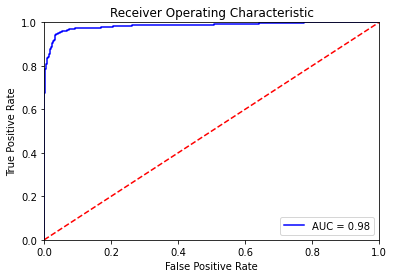

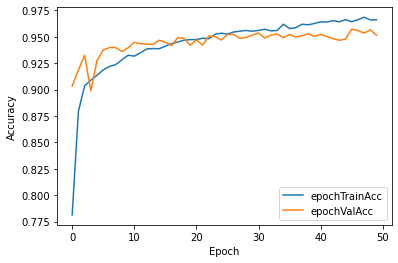

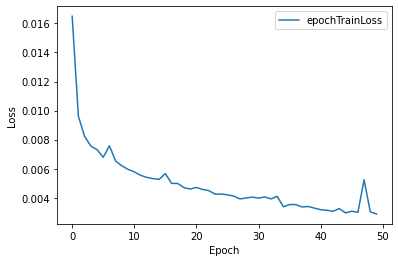

In [9]:
# %matplotlib

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def getRocAucCurve(model, dataLoader):
    model = model.to(device)

    model.eval()
    numberOfImages = 0
    classesAll = torch.tensor([], dtype=torch.float32)
    outputsAll = torch.tensor([], dtype=torch.float32)

    for inputs, classes in tqdm(dataLoader):
            batchSize = inputs.shape[0]
            inputs = inputs.to(device)
            classes = classes.to(device)
            classes = classes.view(classes.shape[0], 1).to(torch.float32)
            outputs = model(inputs.to(torch.float32))
            classesAll = torch.cat((classesAll, classes.cpu()), 0)
            outputsAll = torch.cat((outputsAll, outputs.cpu()), 0)

    fpr, tpr, threshold = roc_curve(classesAll.detach().numpy(), torch.sigmoid(outputsAll).detach().numpy())
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    return fpr, tpr, threshold, roc_auc

getRocAucCurve(model, valDataLoader)

pandas.DataFrame({'epochTrainAcc': epochTrainAcc, 'epochValAcc': epochValAcc}).plot(xlabel='Epoch', ylabel='Accuracy')
pandas.DataFrame({'epochTrainLoss': epochTrainLoss}).plot(xlabel='Epoch', ylabel='Loss')

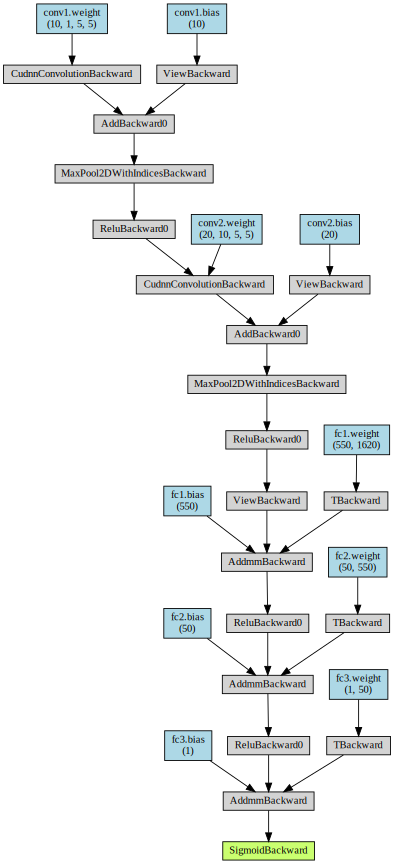

In [10]:
from torchviz import make_dot

inputs, classes = next(iter(valDataLoader))
inputs = inputs.to(device)
output = model.predict(inputs)

make_dot(output, params=dict(list(model.named_parameters())))

## Test

Text(0.5, 1.0, 'Class of image 1, Predicted class 0.9997902512550354')

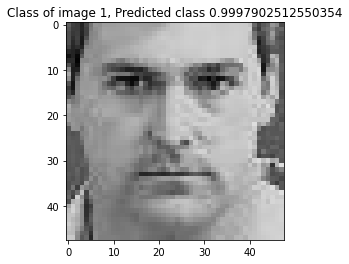

In [11]:
inputs, classes = next(iter(valDataLoader))
inputs = inputs.to(device)
output = model.predict(inputs)

inputs = inputs.cpu()
plt.imshow(inputs[0][0], cmap='gray', vmin=0, vmax=1)
plt.title('Class of image {}, Predicted class {}'.format(classes[0], output[0].item()))

In [12]:
from torchvision import datasets, transforms
from torch.nn import Threshold

#0.41374868
def test(model, device, testDataLoader, path, threshold=0.5):
    model = model.to(device)

    model.eval()
    testBatchAcc = 0
    numberOfImages = 0
    for inputs, classes in tqdm(testDataLoader):
            batchSize = inputs.shape[0]
            inputs = inputs.to(device)
            classes = classes.to(device)
            classes = classes.view(classes.shape[0], 1).to(torch.float32)
            outputs = model(inputs.to(torch.float32))

            results = (torch.sigmoid(outputs) > threshold)
            correct = (classes.eq(results.to(torch.float32))).sum()

            testBatchAcc += correct.item()
            numberOfImages += batchSize

    testBatchAcc = testBatchAcc / numberOfImages

    return testBatchAcc

testTransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    # transforms.Normalize((0.1307,), (0.3081,))
])

testDataLoader = getDataLoader('./test', transforms=testTransforms, batch_size=32, shuffle=True)

model = torch.load('./models/gfcr_v4.pt')
res = test(model, device, testDataLoader, './test')


print('\nTest Accuracy : {}'.format(res))
print('Train Accuracy : {}'.format(epochTrainAcc[-1]))
print('Val Accuracy : {}'.format(epochValAcc[-1]))

100%|██████████| 101/101 [00:00<00:00, 246.63it/s]
Test Accuracy : 0.94454770755886
Train Accuracy : 0.9661016949152542
Val Accuracy : 0.9514180672268908

